This is necessary because I'm using old Docker image compiled for different version: https://blog.ml6.eu/serving-decision-forests-with-tensorflow-b447ea4fc81c 

The `!` sign before commands is for Colab to run the terminal command. Disregard that in normal environment.

In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.5.1 tensorflow_decision_forests==0.1.8 pandas wurlitzer

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
     |████████████████████████████████| 454.4 MB 8.7 kB/s 
     |████████████████████████████████| 6.3 MB 38.4 MB/s 
     |████████████████████████████████| 462 kB 53.9 MB/s 
     |████████████████████████████████| 1.2 MB 18.2 MB/s 
     |████████████████████████████████| 14.8 MB 45.5 MB/s 
     |████████████████████████████████| 132 kB 58.1 MB/s 
     |████████████████████████████████| 4.0 MB 40.0 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68726 sha256=52611b8e391f868b50a78a311688fc790e55934967cb91037e381f74f1e4c6d4
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

print('TensorFlow version: {}'.format(tf.__version__))
# should be 2.5.1

TensorFlow version: 2.5.1


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

TRAINING_FILE = "/content/gdrive/MyDrive/DATA/training_dataset.csv"
TESTING_FILE = "/content/gdrive/MyDrive/DATA/testing_dataset.csv"
TRAINING_DATASET = pd.read_csv(TRAINING_FILE)
TESTING_DATASET = pd.read_csv(TESTING_FILE)
#print('Number of records in training dataset: {}'.format(TRAINING_DATASET.count()))
TRAINING_DATASET.info()
# Display the first 3 examples.
TRAINING_DATASET.head(5)


Mounted at /content/gdrive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43941 entries, 0 to 43940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   has_ip                    43941 non-null  int64
 1   is_url_short              43941 non-null  int64
 2   get_dots_in_hostname      43941 non-null  int64
 3   has_at_sign               43941 non-null  int64
 4   has_double_slash          43941 non-null  int64
 5   has_hyphen_domain         43941 non-null  int64
 6   has_https                 43941 non-null  int64
 7   get_host_length           43941 non-null  int64
 8   has_hyphen_or_underscore  43941 non-null  int64
 9   get_base_url_length       43941 non-null  int64
 10  is_phishing               43941 non-null  int64
dtypes: int64(11)
memory usage: 3.7 MB


,has_ip,is_url_short,get_dots_in_hostname,has_at_sign,has_double_slash,has_hyphen_domain,has_https,get_host_length,has_hyphen_or_underscore,get_base_url_length,is_phishing
0,0,0,1,0,0,0,0,6,1,158,0
1,0,0,2,0,0,0,1,16,1,47,1
2,0,0,1,0,0,0,0,13,0,37,1
3,0,0,1,0,0,0,0,12,0,73,0
4,0,0,1,0,0,0,0,12,1,43,1


Convert pandas dataframe into tensorflow dataset

In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(TRAINING_DATASET, label="is_phishing")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(TESTING_DATASET, label="is_phishing")

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:1224: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  (dict(dataframe.drop(label, 1)), dataframe[label].values))


Train the model
Note:
No input features are specified. Therefore, all the columns will be used as input features except for the label. The feature used by the model are shown in the training logs and in the model.summary()

In [ ]:
# Specify the model.
model = tfdf.keras.RandomForestModel(compute_oob_variable_importances=True)

# Optionally, add evaluation metrics.
model.compile(metrics=["accuracy"])

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs. It doesn't work for some reason.
#with sys_pipes():
model.fit(x=train_ds)

687/687 [==============================] - 6s 2ms/step


Default TF-serving produces error. Finally found why that's happening. The explanation:
>TensorFlow Serving is a serving system for TensorFlow models in production environments. The TF-Serving team publishes a pre-compiled release containing only Core TensorFlow ops.

>TensorFlow Decision Forests (TF-DF) models use custom Ops for inference. Therefore, they are not compatible with the pre-compiled releases of TF-Serving. The solution to serve TF-DF models with TF-Serving is to re-compile TF-Serving with TF-DF ops. This document explains how to do so.

https://github.com/tensorflow/decision-forests/blob/main/documentation/tensorflow_serving.md

In [ ]:
MODEL_DIR = "/content/gdrive/MyDrive/phishingModelAllUrlFeatures_v4"
# model_1.save("/content/gdrive/MyDrive/firstModelSave")
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
#import tempfile

version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}


export_path = /content/gdrive/MyDrive/phishingModelAllUrlFeatures_v4/1

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/phishingModelAllUrlFeatures_v4/1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/phishingModelAllUrlFeatures_v4/1/assets



Saved model:
total 147
drwx------ 2 root root   4096 Apr 17 23:02 assets
-rw------- 1 root root   2438 Apr 17 23:02 keras_metadata.pb
-rw------- 1 root root 139160 Apr 17 23:02 saved_model.pb
drwx------ 2 root root   4096 Apr 17 23:02 variables


In [ ]:
evaluation = model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")


171/171 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9832

loss: 0.0000
accuracy: 0.9832


In [ ]:
model.summary()

Model: "random_forest_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (10):
	get_base_url_length
	get_dots_in_hostname
	get_host_length
	has_at_sign
	has_double_slash
	has_https
	has_hyphen_domain
	has_hyphen_or_underscore
	has_ip
	is_url_short

No weights

Variable Importance: MEAN_DECREASE_IN_ACCURACY:
    1.          "get_host_length"  0.082725 ################
    2.      "get_base_url_length"  0.062038 ###########
    3. "has_hyphen_or_underscore"  0.023918 ####
    4.     "get_dots_in_hostname"  0.018320 ###
    5.                "has_https"  0.004256 
    6.        "has_hyphen_domain"  0.003664 
    7.             "is_url_short"  0.000637 
    8.         "has_double_slash"  0.000546 
    9. 

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3) # this values seems to be default - calling just with `(model)` has same result

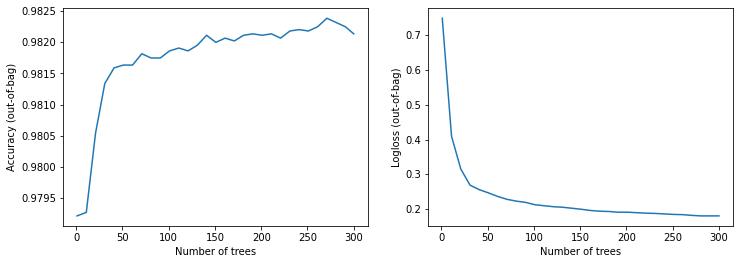

In [ ]:
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

#plt.show()
#plt.savefig("/content/gdrive/MyDrive/matplotAccuracyLogloss2.png")
plt.savefig("/content/gdrive/MyDrive/matplotAccuracyLogloss2.svg", format="svg")

In [ ]:
inspector = model.make_inspector()
print("Model type:", inspector.model_type())
print("Number of trees:", inspector.num_trees())
print("Objective:", inspector.objective())
print("Input features:", inspector.features())

Model type: RANDOM_FOREST
Number of trees: 300
Objective: Classification(label=__LABEL, class=None, num_classes=2)
Input features: ["get_base_url_length" (1; #0), "get_dots_in_hostname" (1; #1), "get_host_length" (1; #2), "has_at_sign" (1; #3), "has_double_slash" (1; #4), "has_https" (1; #5), "has_hyphen_domain" (1; #6), "has_hyphen_or_underscore" (1; #7), "has_ip" (1; #8), "is_url_short" (1; #9)]


In [ ]:
# The feature importances
inspector.variable_importances()

{'MEAN_DECREASE_IN_ACCURACY': [("get_host_length" (1; #2),
   0.08272457122802734),
  ("get_base_url_length" (1; #0), 0.06203770637512207),
  ("has_hyphen_or_underscore" (1; #7), 0.02391839027404785),
  ("get_dots_in_hostname" (1; #1), 0.018320024013519287),
  ("has_https" (1; #5), 0.004255712032318115),
  ("has_hyphen_domain" (1; #6), 0.003663957118988037),
  ("is_url_short" (1; #9), 0.0006371736526489258),
  ("has_double_slash" (1; #4), 0.0005461573600769043),
  ("has_ip" (1; #8), 4.547834396362305e-05),
  ("has_at_sign" (1; #3), 0.0)],
 'MEAN_DECREASE_IN_AP_2_VS_OTHERS': [("get_host_length" (1; #2),
   0.04058280895765232),
  ("get_base_url_length" (1; #0), 0.03996877761302142),
  ("get_dots_in_hostname" (1; #1), 0.010264920796618893),
  ("has_hyphen_or_underscore" (1; #7), 0.007972946796703906),
  ("has_hyphen_domain" (1; #6), 0.004826055730493661),
  ("has_https" (1; #5), 0.004210145188238701),
  ("has_double_slash" (1; #4), 0.0019639624830876112),
  ("is_url_short" (1; #9), 0.001

In [ ]:
inspector.variable_importances()['MEAN_DECREASE_IN_ACCURACY']

[("get_host_length" (1; #2), 0.08272457122802734),
 ("get_base_url_length" (1; #0), 0.06203770637512207),
 ("has_hyphen_or_underscore" (1; #7), 0.02391839027404785),
 ("get_dots_in_hostname" (1; #1), 0.018320024013519287),
 ("has_https" (1; #5), 0.004255712032318115),
 ("has_hyphen_domain" (1; #6), 0.003663957118988037),
 ("is_url_short" (1; #9), 0.0006371736526489258),
 ("has_double_slash" (1; #4), 0.0005461573600769043),
 ("has_ip" (1; #8), 4.547834396362305e-05),
 ("has_at_sign" (1; #3), 0.0)]

In [ ]:
# number_of_use[F] will be the number of node using feature F in its condition.
import collections
number_of_use = collections.defaultdict(lambda: 0)

# Iterate over all the nodes in a Depth First Pre-order traversals.
for node_iter in inspector.iterate_on_nodes():

  if not isinstance(node_iter.node, tfdf.py_tree.node.NonLeafNode):
    # Skip the leaf nodes
    continue

  # Iterate over all the features used in the condition.
  # By default, models are "oblique" i.e. each node tests a single feature.
  for feature in node_iter.node.condition.features():
    number_of_use[feature] += 1

print("Number of condition nodes per features:")
for feature, count in number_of_use.items():
  print("\t", feature.name, ":", count)

Number of condition nodes per features:
	 get_dots_in_hostname : 6664
	 get_base_url_length : 81926
	 get_host_length : 36940
	 is_url_short : 3403
	 has_https : 6529
	 has_hyphen_or_underscore : 7564
	 has_double_slash : 1521
	 has_hyphen_domain : 3253
	 has_at_sign : 329
	 has_ip : 487


In [ ]:
# This cell start TensorBoard that can be slow.
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension


In [ ]:
# Clear existing results (if any)
!rm -fr "/tmp/tensorboard_logs"


In [ ]:
# Export the meta-data to tensorboard.
inspector.export_to_tensorboard("/tmp/tensorboard_logs")

In [ ]:
# Retraining the model with the metrics such as true positives
model_false_positive = tfdf.keras.RandomForestModel()

# Optionally, add evaluation metrics.
model_false_positive.compile(metrics=[tf.keras.metrics.BinaryAccuracy(),
                         tf.keras.metrics.TruePositives(),
                         tf.keras.metrics.TrueNegatives(),
                         tf.keras.metrics.FalsePositives(),
                         tf.keras.metrics.FalseNegatives()])

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs. It doesn't work for some reason.
#with sys_pipes():
model_false_positive.fit(x=train_ds)


687/687 [==============================] - 13s 3ms/step


In [ ]:
evaluation = model_false_positive.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

171/171 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9832 - true_positives_1: 3824.0000 - true_negatives_1: 6908.0000 - false_positives_1: 41.0000 - false_negatives_1: 142.0000

loss: 0.0000
binary_accuracy: 0.9832
true_positives_1: 3824.0000
true_negatives_1: 6908.0000
false_positives_1: 41.0000
false_negatives_1: 142.0000
